# Virtual Batch Normalization implementation and application on CIFAR-10

We will implement virutal batch normalization as introduced in: https://arxiv.org/abs/1606.03498

We will then use it for a conditional DCGAN using the CIFAR-10 dataset.

This implementation requires **Tensorflow 2.0**. The first few cells are only related to Google Colab and Google Drive, you can ignore them.

In [2]:
! pip install tensorflow-gpu==2.0.0-beta1

If executing on Google Colab, mount your Google Drive (click the link, connect and enter the password)

In [3]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("drive/My Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports, helper functions and preliminaries

Importing the libraries

In [0]:
# Coding
import tensorflow as tf 
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import numpy as np

# Plotting and manipulating images
import matplotlib.pyplot as plt
import imageio
import glob
import PIL
from IPython import display

# Timing
import datetime
import time

# Managing the folders 
import os
import shutil

Creating the folders

In [0]:
# Removing the old images generated during training

NAME_FILE = "Virtual batch normalization"

rm_path = "." + os.sep + NAME_FILE + os.sep + "imgs"
if os.path.exists(rm_path):
    shutil.rmtree(rm_path)

# Creating folders to save images, models and checkpoints
newpaths = ["." + os.sep + NAME_FILE + os.sep + "imgs", 
            "." + os.sep + NAME_FILE + os.sep + "models",
            "." + os.sep + NAME_FILE + os.sep + "losses"]
for newpath in newpaths:
    if not os.path.exists(newpath):
        os.makedirs(newpath)

Helper functions

In [0]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

CLASSES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
NUM_CLASSES = len(CLASSES)

def generate_and_save_images(model,
                             epoch,
                             test_input,
                             conditions,
                             g_loss,
                             d_loss,
                             x_axis="scale",
                             y_max=10):

  # Notice `training` is set to False.
    model([ref_batch[:len(test_input)], conditions[:len(test_input)]], training=False)
    predictions = model([test_input, conditions], training=False)

    fig = plt.figure(figsize=(20,8))
    outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

    inner_im = gridspec.GridSpecFromSubplotSpec(4, 5,
                  subplot_spec=outer[0], wspace=0.1, hspace=0.1)

    for i in range(predictions.shape[0]):
        ax = plt.Subplot(fig, inner_im[i])
        ax.imshow((predictions[i]+1) / 2 )
        ax.title.set_text(CLASSES[np.argmax(conditions[i])])
        ax.axis('off')
        fig.add_subplot(ax)
        fig.savefig("." + os.sep + NAME_FILE + os.sep + 'imgs' + os.sep + 'image_at_epoch_{:04d}.png'.format(epoch), bbox_inches="tight")
    
    
    inner_l = gridspec.GridSpecFromSubplotSpec(1, 1,
                  subplot_spec=outer[1], wspace=0.1, hspace=0.1)
    
    ax1 = plt.Subplot(fig, inner_l[0])
    
    samples = 1000
    g_losses_sampled = []
    d_losses_sampled = []
    xs = []

    for i in range(len(g_loss) // samples):
        g_losses_sampled.append(np.mean(g_loss[i*samples:(i+1)*samples]))
        d_losses_sampled.append(np.mean(d_loss[i*samples:(i+1)*samples]))
        xs.append(i*samples + samples/2)

    ax1.plot(xs, g_losses_sampled, "r-")
    ax1.plot(xs, d_losses_sampled, "b-")

    red_patch = mpatches.Patch(color='red', label='Generator loss')
    blue_patch = mpatches.Patch(color='blue', label='Discriminator loss')
    ax1.legend(handles=[red_patch,blue_patch])
    
    if x_axis == "total":
        ax1.set_xlim([0, 50000//BATCH_SIZE * EPOCHS])
    else:
        ax1.set_xlim([0, xs[-1] + xs[-1]*0.1])
    ax1.set_ylim([0, y_max])
    
    
    
    fig.add_subplot(ax1)
    
    plt.show()

# Hyperparameters

In [0]:
# Training parameters
EPOCHS =         200
BATCH_SIZE =     128       # Amount of images processed before backpropagating

# Models parameters
NOISE_DIM =      100      # Amount of features for the generator
KERNEL_SIZE =    (5, 5)   # Larger kernel size for the Convolution layers
MOMENTUM =       0.9      # Momentum for the Batch Normalization layers
DROPOUT =        0.4      # Dropout rate
ALPHA =          0.2      # Alpha for the LeakyReLU slope

# Optimizer parameters
LEARNING_RATE =  2e-4     # Better learning rate for the Adam Optimizer
BETA_1 =         0.5      # Beta_1 for the Adam Optimizer
BETA_2 =         0.9      # Beta_2 for the Adam Optimizer

# Display parameters
NUM_EXAMPLES =   20       # Amount of examples to generate

# Data loading and preprocessing

Loading and preprocessing the dataset. We will use CIFAR-10.

In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

# Shape of the training dataset
IMAGE_SIZE =     train_images.shape[-2] # Size of the images of the training dataset (width and height)
IMAGE_CHANNELS = train_images.shape[-1] # Amount of channels of the training dataset (depth)

# Preprocessing the dataset
train_images = train_images.reshape(train_images.shape[0], IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_labels = tf.one_hot(train_labels, NUM_CLASSES)
train_labels = tf.reshape(train_labels, (train_labels.shape[0], train_labels.shape[2]))

#Virtual Batch Normalization layer

This is the VBN implmentation, with a small trick to help training.
We initialize our reference statistics as None.
Then when passing through the layer, if they are None, we set them to our batch statistics and if they aren't None we use them and then set them to None.

During training we will then first go through the network with our reference batch and then our true batch.

In [0]:
#Flattened input
class VirtualBatchNormalization(tf.keras.layers.Layer):
    def __init__(self,
                 epsilon=1e-5,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 **kwargs):
        
        self.epsilon = epsilon
        self.beta_initializer = beta_initializer
        self.gamma_initializer = gamma_initializer
        self.batch_size = BATCH_SIZE
        
        self.ref_mean = None
        self.ref_mean_sq = None
            
        super(VirtualBatchNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        #Pas convaincu du -1 mdr
        self.gamma = self.add_weight(name='gamma', 
                                      shape=(input_shape[-1],),
                                      initializer=self.gamma_initializer,
                                      trainable=True)
        
        self.beta = self.add_weight(name='beta', 
                                      shape=(input_shape[-1],),
                                      initializer=self.beta_initializer,
                                      trainable=True)
    
        super(VirtualBatchNormalization, self).build(input_shape)  # Be sure to call this at the end
    
    def call(self, x, training=None):
        #Getting training value to know if we are in inference or not
        if training is None:
            training = K.learning_phase()
        if isinstance(training, int):
            training = bool(training)       

        #If True, we need to update stats (using ref batch)
        if self.ref_mean is None or self.ref_mean_sq is None:
            self.ref_mean = tf.reduce_mean(x, [0,1,2], keepdims=True, name='new_mean')
            self.ref_mean_sq = tf.reduce_mean(tf.square(x), [0,1,2], keepdims=True, name="new_mean_sq") # 0 1 2
            return self._normalize(x, self.ref_mean, self.ref_mean_sq)
        
        #Else, they are set, so we use them
        new_coeff = 1./(self.batch_size + 1)
        old_coeff = 1 - new_coeff
        new_mean = tf.reduce_mean(x, [1,2], keepdims=True, name='new_mean')
        new_mean_sq = tf.reduce_mean(tf.square(x), [1,2], keepdims=True, name="new_mean_sq")
        mean = new_coeff * new_mean + old_coeff * self.ref_mean
        mean_sq = new_coeff * new_mean_sq + old_coeff * self.ref_mean_sq
        
        out = self._normalize(x, mean, mean_sq)
        self.ref_mean = None
        self.ref_mean_sq = None
        return out
        
    def _normalize(self, x, mean, mean_sq):
        std = tf.sqrt(self.epsilon + mean_sq - tf.square(mean))
        beta = tf.reshape(self.beta,[1,1,1,-1])
        gamma = tf.reshape(self.gamma,[1,1,1,-1])
        
        out = x - mean
        out = x / std
        out = out * gamma
        out = out + beta
        return out
    
    def compute_output_shape(self, input_shape):
        return input_shape[0]
      
    def get_config(self):
        config = super().get_config()
        config['epsilon'] =  self.epsilon
        config['beta_initializer'] = self.beta_initializer
        config["gamma_initializer"] = self.gamma_initializer
        return config


# Generator and Discriminator architectures

In this section, we will detail what architectures are used for training the conditional DCGAN.

**For our generator, we will use the following architecture :**

In [0]:
def generator_model(input_layer, condition_layer, verbose=False):
    
    #Change par ReLu ?
    #initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)
    
    merged_in = layers.Concatenate()([input_layer, condition_layer])
    
    hid = layers.Dense(4 * 4 * 256, use_bias=False)(merged_in)
    hid = layers.Reshape((4, 4, 256))(hid)
    hid = VirtualBatchNormalization()(hid)

    hid = layers.Conv2DTranspose(256,   kernel_size=KERNEL_SIZE, strides=(2, 2), padding='same', activation="relu", use_bias=False)(hid)
    hid = VirtualBatchNormalization()(hid)

    hid = layers.Conv2DTranspose(128,   kernel_size=KERNEL_SIZE, strides=(2, 2), padding='same', activation="relu", use_bias=False)(hid)
    hid = VirtualBatchNormalization()(hid)

    hid = layers.Conv2DTranspose(64,    kernel_size=KERNEL_SIZE, strides=(2, 2), padding='same', activation="relu", use_bias=False)(hid)
    hid = VirtualBatchNormalization()(hid)
    
    out = layers.Conv2D(IMAGE_CHANNELS, kernel_size=KERNEL_SIZE, strides=(1, 1), padding='same', activation='tanh', use_bias=False)(hid)
    
    
    model = tf.keras.Model(inputs=[input_layer, condition_layer], outputs=out)
    if verbose:
        model.summary()
    
    return model

**For our discriminator, we will use the following architecture :**

In [0]:
def discriminator_model(input_layer, condition_layer, verbose=False):

    
    hid = layers.Conv2D(64,  kernel_size=KERNEL_SIZE, strides=(2, 2), padding='same')(input_layer)
    hid = layers.BatchNormalization(momentum=0.9)(hid)                            
    hid = layers.LeakyReLU(alpha=0.2)(hid)

    hid = layers.Conv2D(128, kernel_size=KERNEL_SIZE, strides=(2, 2), padding='same')(hid)
    hid = layers.BatchNormalization(momentum=0.9)(hid)                            
    hid = layers.LeakyReLU(alpha=0.2)(hid)

    hid = layers.Conv2D(256, kernel_size=KERNEL_SIZE, strides=(2, 2), padding='same')(hid)
    hid = layers.BatchNormalization(momentum=0.9)(hid)
    hid = layers.LeakyReLU(alpha=0.2)(hid)

    hid = layers.Flatten()(hid)

    hid = layers.Dense(256)(hid)
    hid = layers.LeakyReLU(alpha=0.2)(hid)
    
    merged = layers.Concatenate()([hid, condition_layer])

   # hid = MinibatchDiscrimination(num_kernel=128, dim_kernel=5, name="minibatch_discrimination")(hid)
    
    hid = layers.Dense(256)(merged)
    hid = layers.LeakyReLU(alpha=0.2)(hid)

    out = layers.Dense(1)(hid) # Pas de sigmoide car on prend la Cross Entropy avec from_logits=True
    
    model = tf.keras.Model(inputs=[input_layer, condition_layer], outputs=out)
    if verbose:
        model.summary()
    
    return model

Loading the generator

In [0]:
ref_batch = tf.random.normal([BATCH_SIZE, 100], seed=42)
ref_condition = tf.one_hot( np.random.randint(NUM_CLASSES, size=BATCH_SIZE), NUM_CLASSES)

noise_input = layers.Input(shape=(NOISE_DIM,))
gen_cond_in = layers.Input(shape=(NUM_CLASSES,))

generator = generator_model(noise_input, gen_cond_in)

Loading the discriminator

In [0]:
img_input = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS))
disc_cond_in = layers.Input(shape=(NUM_CLASSES,))
discriminator = discriminator_model(img_input, disc_cond_in)

# Loss functions and optimizers

In [0]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

The discriminator will try to recognize ground truth data by predicting 1, and to recognize the generated images by predicting 0. Thus, we will use the binary crossentropy of the difference between the values predicted and the expected values as a measure of the loss. 

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    # real_loss will quantify our loss to distinguish the real images
    
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    # fake_loss will quantify our loss to distinguish the fake images (generated)
    
    # Real image = 1, Fake image = 0 (array of ones and zeros)
    total_loss = real_loss + fake_loss
    return total_loss

The generator will try to fool the discriminator by making the generated images’ predictions be the closest to 1. We will then use the binary crossentropy of the difference between the discriminator’s predictions over generated data and 1 as a measure of the loss.

In [0]:
def generator_loss(fake_output):
    # We want the false images to be seen as real images (1)
    return loss_function(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, BETA_1, BETA_2)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, BETA_1, BETA_2)

#Training 

We code the train steps manually to have complete control over the process.

In [0]:
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # To make sure we know what is done, we will use a gradient tape instead of compiling
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # For virtual batch normalization to update statistics
        generator([ref_batch, labels], training=False)
        
        # Training the generator
        generated_images = generator([noise, labels] , training=True) 

        # Training the discriminator
        real_output = discriminator([images, labels], training=True)           # Training the discriminator on real images
        fake_output = discriminator([generated_images, labels], training=True) # Training the discriminator on fake images

        # Calculating the losses
        gen_loss =  generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # Building the gradients
        gradients_of_generator =     gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        # Applying the gradients (backpropagation)
        generator_optimizer.apply_gradients(    zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        return gen_loss, disc_loss


In [0]:
g_losses = []
d_losses = []
def train(train_images, train_labels, epochs):

    num_batches = int(train_images.shape[0]/BATCH_SIZE) # Amount of batches
    for epoch in range(epochs):
        start = time.time() # Timing the epoch

        for batch_idx in range(num_batches):
            images = train_images[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
            labels = train_labels[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
            gen_loss, disc_loss = train_step(images, labels)
            
            # Saving the losses
            g_losses.append(gen_loss.numpy())
            d_losses.append(disc_loss.numpy())

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed,
                                 seed_labels,
                                 g_losses,
                                 d_losses,
                                 'total')

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print("Generator loss for last batch: ",g_losses[-1])
        print("Discriminator loss for last batch: ",d_losses[-1])

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epochs,
                               seed,
                               seed_labels,
                               g_losses,
                               d_losses,
                               'total')

We will reuse this seed overtime, so it's easier to visualize progress in the animated GIF.

In [0]:
seed = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])
seed_labels = tf.one_hot([0,1,2,3,4,0,1,2,3,4,5,6,7,8,9,5,6,7,8,9], NUM_CLASSES)

This following cell launches the training.

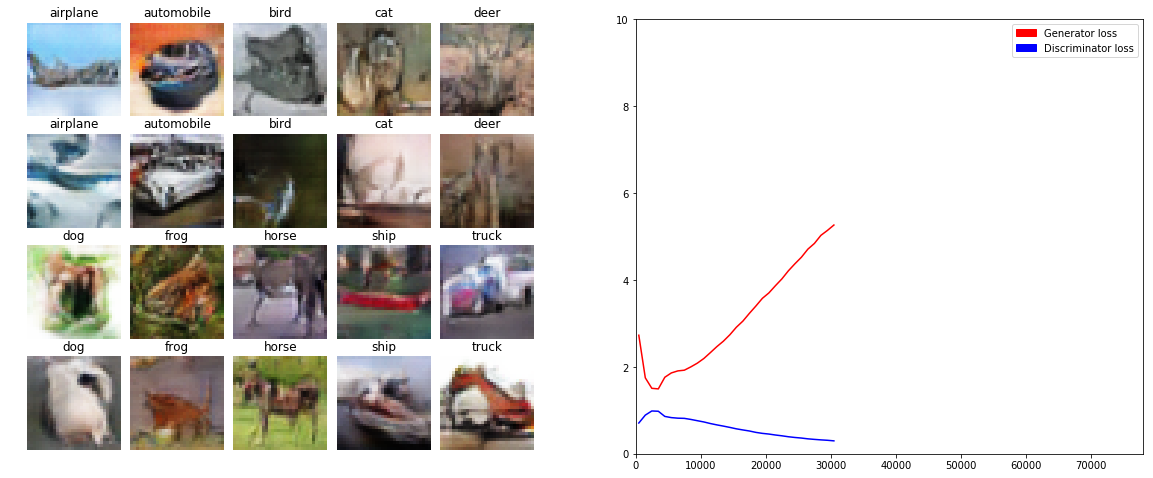

Time for epoch 81 is 93.34454607963562 sec
Generator loss for last batch:  4.797823
Discriminator loss for last batch:  0.20160866


KeyboardInterrupt: ignored

In [21]:
%%time
# Training
train(train_images, train_labels, EPOCHS)

# Immedialty save the models 
generator.save(    "." + os.sep + NAME_FILE + os.sep + 'models' + os.sep + 'generator.h5')
discriminator.save("." + os.sep + NAME_FILE + os.sep + 'models' + os.sep + 'discriminator.h5')

In [0]:
generator.save(    "." + os.sep + NAME_FILE + os.sep + 'models' + os.sep + 'generator.h5')
discriminator.save("." + os.sep + NAME_FILE + os.sep + 'models' + os.sep + 'discriminator.h5')

np.save("." + os.sep + NAME_FILE + os.sep + 'losses' + os.sep + 'g_losses_cond.npy',g_losses)
np.save("." + os.sep + NAME_FILE + os.sep + 'losses' + os.sep + 'd_losses_cond.npy',d_losses)

In [26]:
# generator_l =     tf.keras.models.load_model("." + os.sep + NAME_FILE + os.sep + "models" + os.sep + "generator.h5")
discriminator_l = tf.keras.models.load_model("." + os.sep + NAME_FILE + os.sep + "models" + os.sep + "discriminator.h5")
generator_l =     tf.keras.models.load_model("." + os.sep + NAME_FILE + os.sep + "models" + os.sep + "generator.h5", custom_objects={'VirtualBatchNormalization':VirtualBatchNormalization,})

W0624 19:05:00.770268 139938020231040 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0624 19:05:01.609061 139938020231040 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


#Sample generation from a specific class

In [0]:
def show_class(model, k):
    print("Generating {} images...".format(CLASSES[k]))
    input = tf.random.normal([20, 100])
    labels = tf.one_hot([k]*20,NUM_CLASSES)
    model([ref_batch[:20], labels], training=False)
    predictions = model([input, labels], training=True)

    fig = plt.figure(figsize=(10,10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 5, i+1)
        plt.title(CLASSES[k])
        plt.imshow((predictions[i]+1) / 2)
        plt.axis('off')
    plt.show()

Generating horse images...


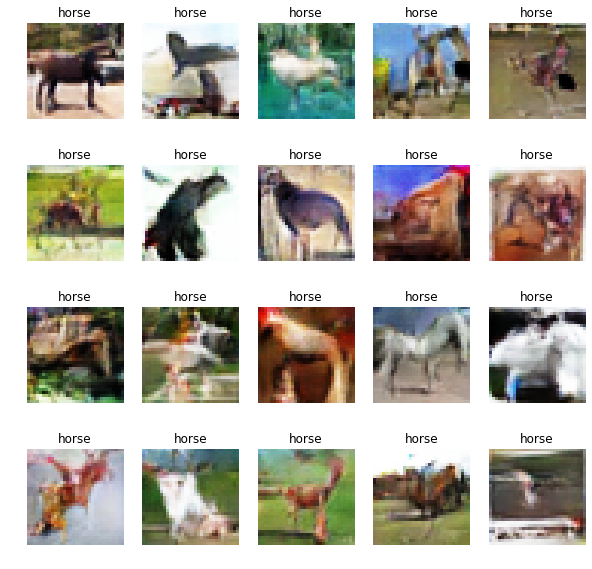

In [28]:
show_class(generator, 7)

# Losses visualization

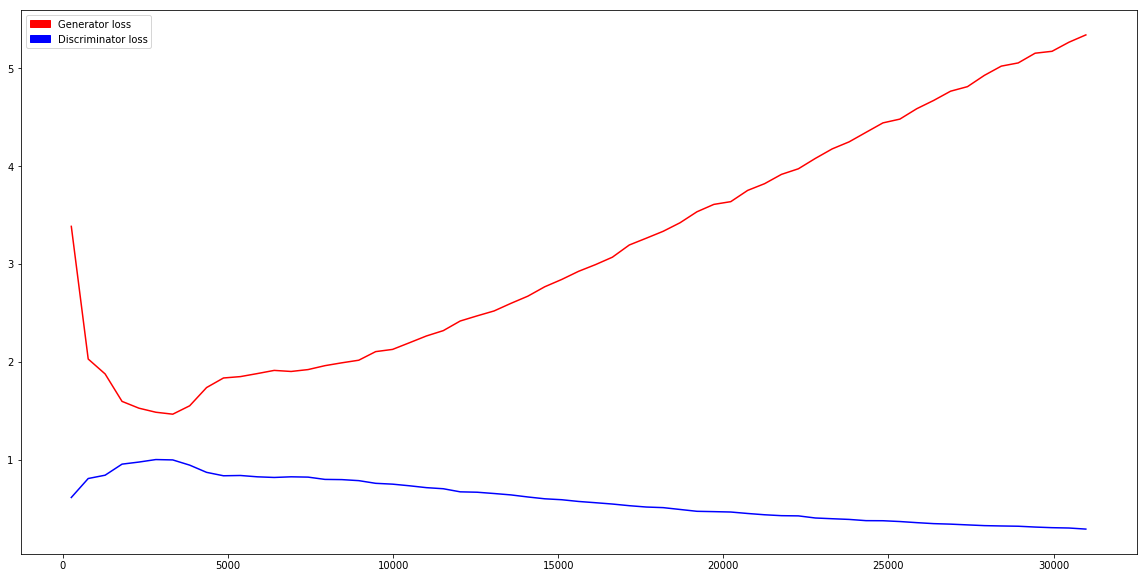

In [29]:
samples = 512
g_losses_sampled = []
d_losses_sampled = []
xs = []


for i in range(len(g_losses) // samples):
    g_losses_sampled.append(np.mean(g_losses[i*samples:(i+1)*samples]))
    d_losses_sampled.append(np.mean(d_losses[i*samples:(i+1)*samples]))
    xs.append(i*samples + samples/2)

plt.figure(figsize=(20,10))
  
plt.plot(xs, g_losses_sampled, "r-")
plt.plot(xs, d_losses_sampled, "b-")

red_patch = mpatches.Patch(color='red', label='Generator loss')
blue_patch = mpatches.Patch(color='blue', label='Discriminator loss')
plt.legend(handles=[red_patch,blue_patch])
plt.show()


# Saving a GIF of images generated during training

In [0]:
anim_file = "." + os.sep + NAME_FILE + os.sep + 'CIFAR-10.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob("." + os.sep + NAME_FILE + os.sep + 'imgs' + os.sep + 'image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 10*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)